#### Character to Mel Spectrogram Sequence Generation Model with location-based Attention

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pickle
sys.path.append('../../')
print(sys.path)
import IPython.display as ipd
import numpy as np
import seaborn as sns; sns.set()
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tools.libaudio.utils import load
from tools.libaudio.feature import melspectrogram
from tools.libaudio.waves import sin_wave
from tools.libaudio.display import show_spec, show_mel
from mlutils.utils import plot, plots, to_onehot
from models.phoneme import Phoneme43
import torch
import torch.nn as nn
import torch.nn.functional as F
from mlutils.utils import time_since, update_lr
from tts.Alternative.neuravoice import CharToMel
from tts.Alternative.train import train_char2mel
from tts.Alternative.dataset import NeuraVoiceDataset
from torch.utils.data import DataLoader
import time

['/var/Sources/experiments/core/tts/Alternative', '/home/kaz/anaconda3/envs/core/lib/python37.zip', '/home/kaz/anaconda3/envs/core/lib/python3.7', '/home/kaz/anaconda3/envs/core/lib/python3.7/lib-dynload', '', '/home/kaz/.local/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/Mako-1.0.7-py3.7.egg', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/IPython/extensions', '/home/kaz/.ipython', '../../']




**RNN Sequence Genetor with location-based Attention**
```

U: char length
c: char sequence
T: timestep length of input x
wt: window into c at timestep t
φ(t, u): window weight of cu at timestep t
αt: parameters control the importance of the window within the mixture
βt: parameters control the width of the window
kt: parameters control the location of the window

ht^1 = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)

(αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer

αt = exp(αhat_t)  # importance of the window
βt = exp(βhat_t)  # width of the window
kt = kt-1 + exp(khat_t)  # location of the window (how far to slide each window)

φ(t, u) = Σk=1->K αt^k exp(-βt^k(kt^k-u)^2)  # discrete convolution of a mixture of K Gaussian


ht^n = H(Wihn xt + Whn-1hn ht^n-1 + Whnhn ht-1^n + Wwhn wt + bh^n)


```

ref. Generating Sequences With Recurrent Neural Networks  
https://arxiv.org/pdf/1308.0850.pdf

**Char to MelSpectrum model**
```
seq of char (n,)
-> embedding (N_char, 512)
-> conv (shape:5x1, filter:512)+batch norm+relu x 3
-> bi-GRU (256 hidden size  x 2)
-> (encoded features)
-> attention network
-> (attention context)
-> residual uni-GRU (1024 hidden size) x 2
-> fully connected (256) x2 + (attention context)
-> residual uni-GRU (1024 hidden size) x 2
-> Mel spectrogram
```
ref. NATURAL TTS SYNTHESIS BY CONDITIONING WAVENET ON MEL SPECTROGRAM PREDICTIONS  
https://arxiv.org/pdf/1712.05884.pdf


Mel Spectrogram

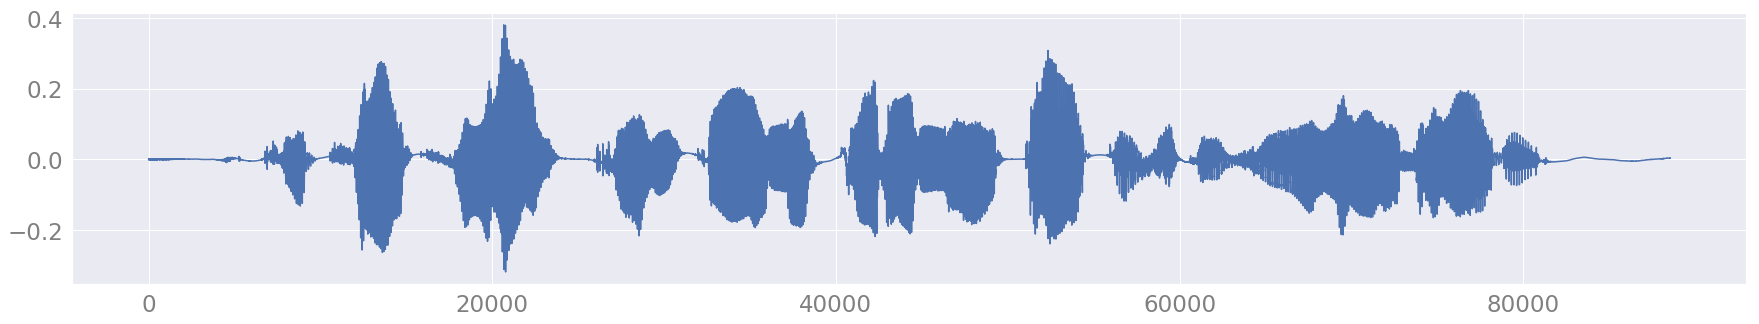

In [2]:
key = 'BASIC5000_0005'
wav_005 = load(f'/diskB/6/Datasets/VoiceData/jsut_ver1.1/basic5000/wav/{key}.wav', sample_rate=24000)
plot(wav_005)

In [3]:
ipd.Audio(wav_005, rate=24000)

In [4]:
text_005 = 'ケツアツハケンコウノバロメータートシテジュウヨウデアル'

In [5]:
wav_005.shape

(88560,)

In [6]:
mel = melspectrogram(wav_005, sample_rate=24000, n_fft=2048, hop_length=300, power=2.0)

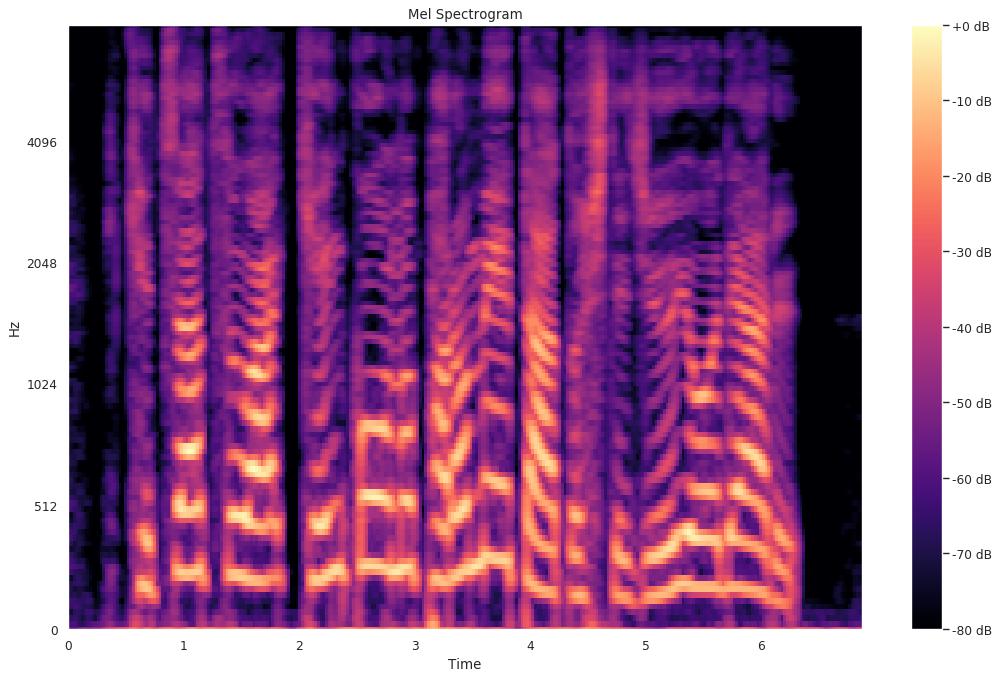

In [7]:
show_mel(mel)

In [8]:
mel = torch.Tensor(mel)
mel.shape

torch.Size([128, 296])

In [9]:
# target_step = 8000
# # https://github.com/vdumoulin/conv_arithmetic#transposed-convolution-animations
# # Hout = (Hin−1)×stride[0]−2×pad[0]+ksize[0](+output_padding[0])
# # Wout = (Win−1)×stride[1]−2×pad[1]+ksize[1](+output_padding[1])
# # (128-1)x1-2x2+3
# transconv = torch.nn.ConvTranspose2d(
#     in_channels=1,
#     out_channels=1,
#     kernel_size=(1, target_size),
#     stride=1,
#     padding=2,
#     output_padding=0,
#     groups=1,
#     bias=True,
#     dilation=1)

In [10]:
# transconv(mel)

In [12]:
#mel_upsample = torch.nn.functional.interpolate(mel.unsqueeze(1), target_step, mode='linear', align_corners=True)
#mel_upsample, mel_upsample.shape

In [14]:
#show_mel(mel_upsample.squeeze())

Phoneme (Character) indices

In [15]:
with open('/diskB/6/Datasets/VoiceData/jsut_ver1.1/preprocessed/segments.pickle', 'rb') as f:
    segments = pickle.load(f)
    print(f'segments[0] {segments[0]}')

segments[0] ('/diskB/6/Datasets/VoiceData/jsut_ver1.1/segmentation_results/all/BASIC5000_1701.log', [(26, 30, 'b'), (31, 36, 'o'), (37, 42, 'k'), (43, 46, 'u'), (47, 54, 'n'), (55, 62, 'a'), (63, 67, 'r'), (68, 80, 'a'), (81, 94, 'n'), (95, 99, 'a'), (100, 108, 'n'), (109, 114, 'i'), (115, 124, 'o'), (125, 133, 'o'), (134, 138, 'i'), (139, 145, 't'), (146, 148, 'e'), (149, 158, 'm'), (159, 172, 'o'), (173, 183, 'd'), (184, 192, 'o:'), (193, 204, 's'), (205, 216, 'o:'), (217, 226, 'k'), (227, 233, 'a'), (234, 236, 'i'), (237, 245, 'w'), (246, 250, 'a'), (251, 260, 'k'), (261, 263, 'a'), (264, 269, 'n'), (270, 274, 'a'), (275, 279, 'r'), (280, 282, 'a'), (283, 291, 'z'), (292, 294, 'u'), (295, 306, 'sh'), (307, 309, 'u'), (310, 312, 'q'), (313, 321, 's'), (322, 327, 'e'), (328, 332, 'k'), (333, 335, 'i'), (336, 345, 's'), (346, 349, 'u'), (350, 353, 'r'), (354, 358, 'u'), (359, 361, 'd'), (362, 367, 'a'), (368, 375, 'r'), (376, 392, 'o'), (393, 395, 'u')])


In [16]:
def search(key):
    for d in segments:
        if d[0].endswith(f'{key}.log'):
            return d

In [17]:
phonemes = [Phoneme43.to_index(phone[2]) for phone in search(key)[1]]

In [18]:
print(phonemes)

[25, 3, 26, 2, 0, 26, 2, 11, 0, 25, 3, 10, 25, 9, 33, 4, 23, 0, 38, 4, 32, 8, 24, 5, 24, 4, 35, 1, 24, 3, 13, 7, 12, 9, 29, 3, 0, 38, 2]


In [19]:
phoneme_names = [Phoneme43(phoneme).name for phoneme in phonemes]
phoneme_names[:10]

['k', 'e', 'ts', 'u', 'a', 'ts', 'u', 'w', 'a', 'k']

Character encoding

In [20]:
vocab_size = len(Phoneme43)

c = torch.LongTensor(to_onehot(phonemes, n_class=vocab_size))

In [21]:
c

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [22]:
c.shape

torch.Size([39, 43])

In [23]:
embed_size = 512
embedding = nn.Embedding(vocab_size, embed_size)

In [24]:
c_emb = embedding(c)

In [25]:
c_emb[0]

tensor([[ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        ...,
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821]],
       grad_fn=<SelectBackward>)

In [26]:
c_emb.shape  # (T, H, W)

torch.Size([39, 43, 512])

In [27]:
class NGramConvolution(torch.nn.Module):
    def __init__(self, embed_size=512, kernel_size=(5, 1)):
        super(NGramConvolution, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.conv3 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.bn1 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.bn2 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.bn3 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.relu3 = torch.nn.ReLU()
    
    def THW2NWTH(self, x):
        x = x.permute(2, 0, 1)
        return x.view(1, x.shape[0], x.shape[1], x.shape[2])
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = self.THW2NWTH(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu2(x)
        x = x.permute(2, 0, 3, 1)  # (T, N, H, W)
        return x

In [28]:
ngc = NGramConvolution(embed_size=embed_size, kernel_size=(5, 1))

In [29]:
%time
c_emb_conv = ngc(c_emb)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


In [30]:
c_emb_conv[0][0]

tensor([[0.0529, 0.3269, 0.0000,  ..., 0.1156, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0376, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000]],
       grad_fn=<SelectBackward>)

In [31]:
c_emb_conv.shape

torch.Size([27, 1, 43, 512])

####  Sequence Generator with location-based Attention

```
x: input sequence
y: mel spectrum sequence
U: char length
c: char sequence
T: timestep length of input x
wt: window vector into c at timestep t
φ(t, u): window weight of cu at timestep t
αt: parameters control the importance of the window within the mixture
βt: parameters control the width of the window
κt: parameters control the location of the window
(eq.46): discrete convolution with a mixture of K Gaussian function

xt ∈ R×R×{0,1}

h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)

(αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer

αt = exp(αhat_t)  # importance of the window
βt = exp(βhat_t)  # width of the window
κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)

φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian


cf. 
normal distribution
N(X|μ,σ2) = 1/(2πσ2)^1/2 exp{-1/2σ2(x-μ)2}

mixture gaussians
p(x) = Σk=1->K πk N(X|μk,Σk)  # where πk:mixing coefficient, μk:mean, Σk:covariance, N(X|μk,Σk):mixture component
p(x) = Σk=1->K πk (1/(2π)^D/2 1/|Σ|^1/2) exp{-1/2(x-μ)^T Σ^-1(x-μ)}  # where Σ:DxD dim covariance matrix, |Σ|:det Σ

wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t

hnt = H(Wihn xt + Whn-1hn hnt-1 + Whnhn hnt-1 + Wwhn wt + bnh)

yˆtˆ = (eˆt,{wˆj_t,μˆJ_t,σˆj_t,ρˆj_t}^M_j=1) = by + Σn=1->N Whny hnt

et = 1 / (1 + exp(eˆt)) ⇒ et∈(0,1) : stroke probability
πtj = exp(πtj) / (Σj't=1->M exp(πtj)) ⇒πtj∈(0,1), Σπtj=1 : mixture weights
μjt = μˆjt ⇒ μjt∈R : means
σtj = exp(σˆtj) ⇒ σˆtj > 0 : std
pjt = tanh(pˆtj) ⇒ pˆtj∈(0,1) : correlations

Pr(x|c) = ∏t=1->T Pr(xt+1|yt)
L(x) = -log Pr(x|c)
```

Input & Output

In [32]:
# c1. onehot
c

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [33]:
c.shape

torch.Size([39, 43])

In [34]:
# c2. onehot embeded
c_emb[0]

tensor([[ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        ...,
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821],
        [ 0.5175, -0.9431, -0.6470,  ...,  1.1517,  1.4574, -0.3821]],
       grad_fn=<SelectBackward>)

In [35]:
c_emb.shape

torch.Size([39, 43, 512])

In [36]:
# c3. onehot embedded 5-gram
c_emb_conv[0][0]

tensor([[0.0529, 0.3269, 0.0000,  ..., 0.1156, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0376, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000],
        [0.0000, 0.0000, 0.0663,  ..., 0.0871, 0.0409, 0.0000]],
       grad_fn=<SelectBackward>)

In [37]:
c_emb_conv.shape

torch.Size([27, 1, 43, 512])

In [38]:
# y. melspectrogram
mel

tensor([[4.1781e-04, 4.2978e-04, 3.8574e-04,  ..., 1.8835e-02, 3.2648e-02,
         4.3341e-02],
        [1.1756e-04, 1.4426e-04, 1.5435e-04,  ..., 2.5821e-04, 3.2323e-04,
         3.2827e-04],
        [2.8792e-05, 4.0903e-05, 6.2976e-05,  ..., 4.9818e-05, 5.0324e-05,
         7.5028e-05],
        ...,
        [3.7895e-07, 4.1616e-07, 3.6224e-07,  ..., 1.5572e-08, 3.1202e-08,
         4.8096e-08],
        [2.7661e-07, 2.4075e-07, 1.4813e-07,  ..., 6.5611e-09, 1.0549e-08,
         1.5595e-08],
        [1.1432e-07, 7.7864e-08, 2.2786e-08,  ..., 8.3096e-10, 2.5113e-09,
         4.2880e-09]])

In [39]:
mel.shape

torch.Size([128, 296])

Parameters

In [40]:
K = 20  # mixture of K Gaussian
padded_text_len = 999   # text length with padding (=max sequence len) from data set
U = vocab_len = n_chars = 43  # num of characters
hidden_size = 256
mel_feature_size = mel.shape[1]  # 296
batch_size = 1
T = max_target_size = 800  # max time step

Input data

In [41]:
# y: mel spectrogram (N, T, H)
x = mel.view(batch_size, mel.shape[0], mel.shape[1])[:, :-1]
y = mel.view(batch_size, mel.shape[0], mel.shape[1])[:, 1:]
x.shape, y.shape

(torch.Size([1, 127, 296]), torch.Size([1, 127, 296]))

In [42]:
# add padding to x according to max_target_size (T) 
x = torch.cat([x, torch.zeros((x.shape[0], T-y.shape[1], x.shape[2]))], dim=1)
y = torch.cat([y, torch.zeros((y.shape[0], T-y.shape[1], y.shape[2]))], dim=1)
x.shape, y.shape

(torch.Size([1, 800, 296]), torch.Size([1, 800, 296]))

In [43]:
# time step 0 for x, y
x[:, 0, :].shape, y[:, 0, :].shape

(torch.Size([1, 296]), torch.Size([1, 296]))

In [44]:
# reshape c:text sequence from (T, H) to (N, T, H)
cx = c.view(batch_size, c.shape[0], c.shape[1])
cx.shape

torch.Size([1, 39, 43])

Hidden Layers

In [45]:
# GRUCell only returns the next hidden state (batch, hidden_size)

# h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h) = H(Wiwh1 (xt + wt-1) + Wh1h1 h1t-1 + b1h)
H1 = torch.nn.GRUCell(input_size=mel_feature_size+vocab_size, hidden_size=hidden_size)
H2 = torch.nn.GRUCell(input_size=mel_feature_size+vocab_size+hidden_size, hidden_size=hidden_size)

In [46]:
# begin with the first timestep
t = 0
xt_1 = x[:, t, :]
assert xt_1.shape[1] == mel_feature_size
xt_1.shape

torch.Size([1, 296])

In [47]:
# the first window is from the first character (phoneme 0: "a")
wt_1 = torch.zeros((batch_size, vocab_size))
wt_1.shape

torch.Size([1, 43])

In [48]:
# initial hidden state
ht_1 = torch.zeros(batch_size, hidden_size)
ht_1.shape

torch.Size([1, 256])

In [49]:
# initial input (N, feature_size+window_size(=vocab_size)))
xt_1_wt_1 = torch.cat([xt_1, wt_1], dim=-1).float()
xt_1_wt_1.shape

torch.Size([1, 339])

In [50]:
# h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)
h1t_1 = H1(xt_1_wt_1, ht_1)
h1t_1.shape

torch.Size([1, 256])

In [51]:
# initial kappa
kappa_t_1 = torch.zeros((batch_size, K))
kappa_t_1.shape

torch.Size([1, 20])

In [52]:
# (αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer
Wh1p = torch.nn.Linear(hidden_size, 3*K)
alpha_beta_kappa = Wh1p(h1t_1)
alpha_t, beta_t, kappa_t = alpha_beta_kappa[:, :K], alpha_beta_kappa[:, K:K*2], alpha_beta_kappa[:, K*2:K*3]
# αt = exp(αhat_t)  # importance of the window
# βt = exp(βhat_t)  # width of the window
# κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)
alpha_t = alpha_t.exp()
beta_t = beta_t.exp()
kappa_t = kappa_t_1 + kappa_t.exp()
alpha_t.shape, beta_t.shape, kappa_t.shape

(torch.Size([1, 20]), torch.Size([1, 20]), torch.Size([1, 20]))

In [53]:
kappa_t.unsqueeze(2).repeat(1, 1, x.shape[1])

tensor([[[0.7369, 0.7369, 0.7369,  ..., 0.7369, 0.7369, 0.7369],
         [1.0748, 1.0748, 1.0748,  ..., 1.0748, 1.0748, 1.0748],
         [1.0425, 1.0425, 1.0425,  ..., 1.0425, 1.0425, 1.0425],
         ...,
         [1.0948, 1.0948, 1.0948,  ..., 1.0948, 1.0948, 1.0948],
         [1.1350, 1.1350, 1.1350,  ..., 1.1350, 1.1350, 1.1350],
         [1.0221, 1.0221, 1.0221,  ..., 1.0221, 1.0221, 1.0221]]],
       grad_fn=<RepeatBackward>)

In [54]:
torch.Tensor(range(U)).view(1, -1)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42.]])

In [55]:
u = torch.Tensor(range(c.shape[1])).view(1, -1)
kappa_t.unsqueeze(2).repeat(1, 1, c.shape[1]) - u

tensor([[[ 7.3692e-01, -2.6308e-01, -1.2631e+00, -2.2631e+00, -3.2631e+00,
          -4.2631e+00, -5.2631e+00, -6.2631e+00, -7.2631e+00, -8.2631e+00,
          -9.2631e+00, -1.0263e+01, -1.1263e+01, -1.2263e+01, -1.3263e+01,
          -1.4263e+01, -1.5263e+01, -1.6263e+01, -1.7263e+01, -1.8263e+01,
          -1.9263e+01, -2.0263e+01, -2.1263e+01, -2.2263e+01, -2.3263e+01,
          -2.4263e+01, -2.5263e+01, -2.6263e+01, -2.7263e+01, -2.8263e+01,
          -2.9263e+01, -3.0263e+01, -3.1263e+01, -3.2263e+01, -3.3263e+01,
          -3.4263e+01, -3.5263e+01, -3.6263e+01, -3.7263e+01, -3.8263e+01,
          -3.9263e+01, -4.0263e+01, -4.1263e+01],
         [ 1.0748e+00,  7.4772e-02, -9.2523e-01, -1.9252e+00, -2.9252e+00,
          -3.9252e+00, -4.9252e+00, -5.9252e+00, -6.9252e+00, -7.9252e+00,
          -8.9252e+00, -9.9252e+00, -1.0925e+01, -1.1925e+01, -1.2925e+01,
          -1.3925e+01, -1.4925e+01, -1.5925e+01, -1.6925e+01, -1.7925e+01,
          -1.8925e+01, -1.9925e+01, -2.0925e+01, -

In [56]:
u = torch.Tensor(range(U)).view(1, -1)
a = alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2)*(kappa_t.unsqueeze(2).repeat(1, 1, U) - u)**2).exp()
#a = a.sum(dim=1) / K
#a = a.squeeze(0).detach().numpy()
#plot(a)
a, a.shape

(tensor([[[5.5770e-01, 9.0276e-01, 1.9137e-01, 5.3122e-03, 1.9311e-05,
           9.1928e-09, 5.7308e-13, 4.6784e-18, 5.0015e-24, 7.0020e-31,
           1.2837e-38, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.6906e-01, 1.0350e+00, 4.8262e-01, 3.7424e-02, 4.8257e-04,
           1.0347e-06, 3.6892e-10, 2.1873e-14, 2.1565e-19, 3.5354e-25,
           9.6379e-32, 4.3691e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000

In [57]:
 (kappa_t.unsqueeze(2).repeat(1, 1, cx.shape[0]) - torch.Tensor(range(cx.shape[0])))**2

tensor([[[0.5430],
         [1.1551],
         [1.0869],
         [1.0381],
         [0.9937],
         [0.9214],
         [0.9989],
         [0.8803],
         [1.7156],
         [0.9766],
         [0.9233],
         [0.9660],
         [0.9994],
         [0.7722],
         [0.9076],
         [1.1384],
         [1.1250],
         [1.1986],
         [1.2881],
         [1.0447]]], grad_fn=<PowBackward0>)

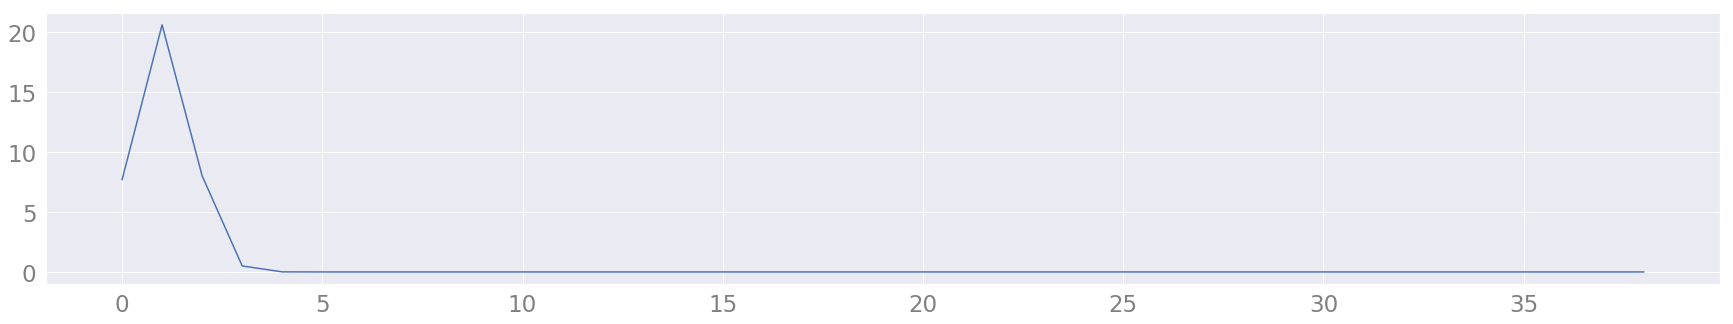

In [58]:
# φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian

# unefficient way
#phi_t = torch.stack([alpha_t*(-beta_t*(kappa_t-u)**2).exp() for u in range(x.shape[1])]).permute(1, 2, 0)  # (N, K, U)
#phi_t = torch.sum(phi_t, dim=1)  # linear combination of K columns to a mixture distribution length U (N, U)
#phi_t, phi_t.shape

u = torch.Tensor(range(c.shape[0]))
phi_t = (alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2) * (kappa_t.unsqueeze(2).repeat(1, 1, c.shape[0]) - u)**2).exp()).sum(dim=1)
phi_t, phi_t.shape

#u = torch.Tensor(range(U))
#phi_t = (alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2) * (kappa_t.unsqueeze(2).repeat(1, 1, U) - u)**2).exp()).sum(dim=1)
#phi_t, phi_t.shape
#alpha_t*(-beta_t*(kappa_t-0)**2).exp()
plot(phi_t.squeeze(0).detach().numpy())

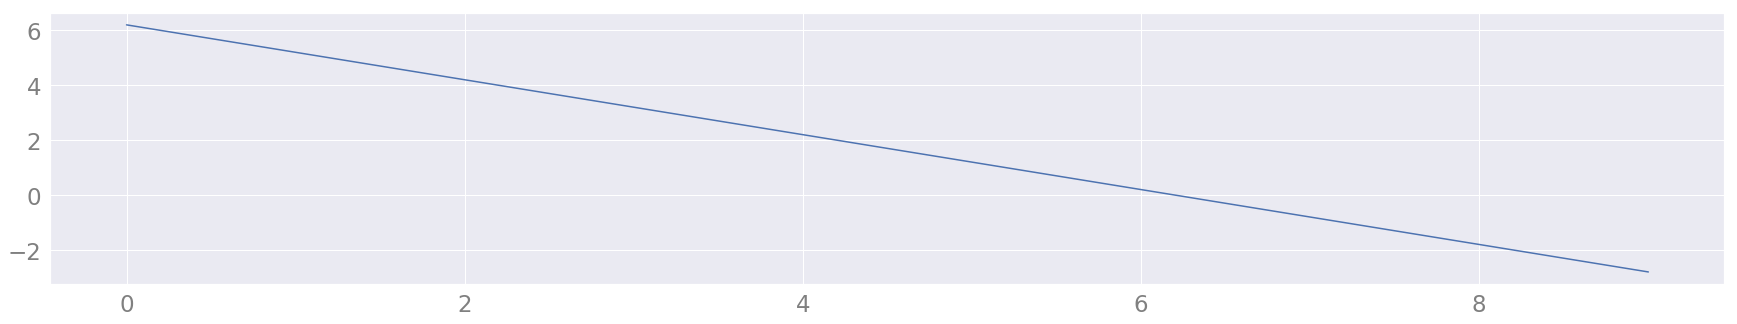

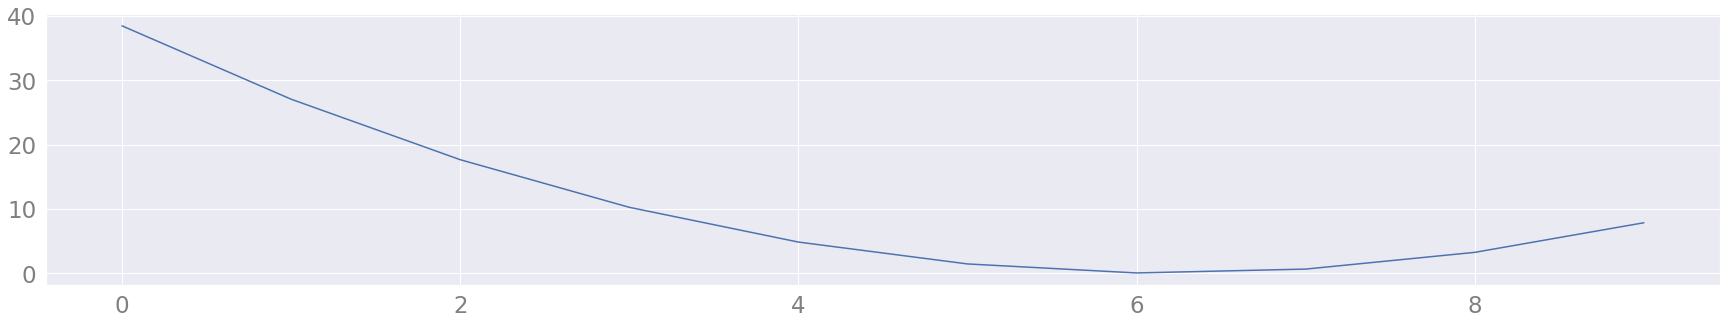

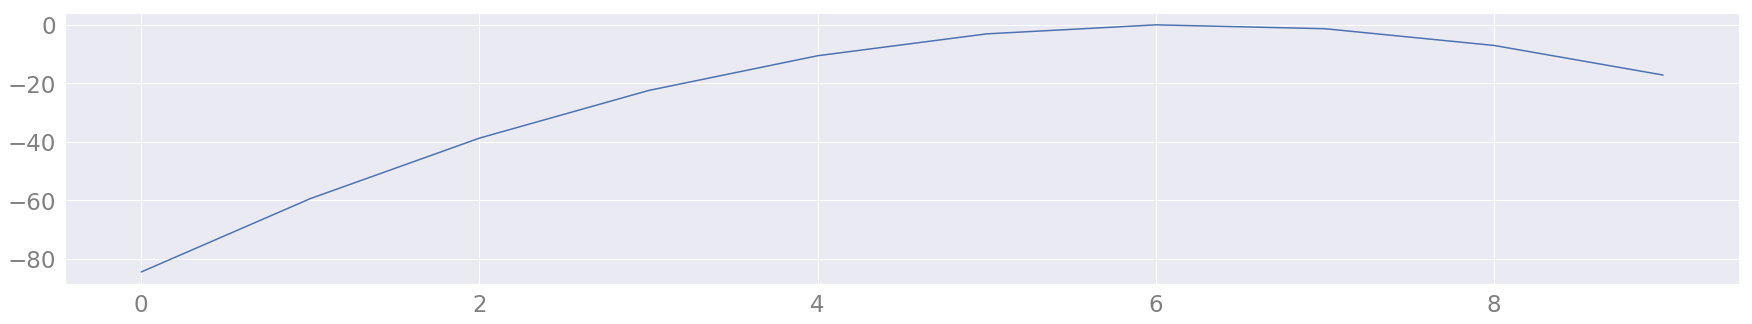

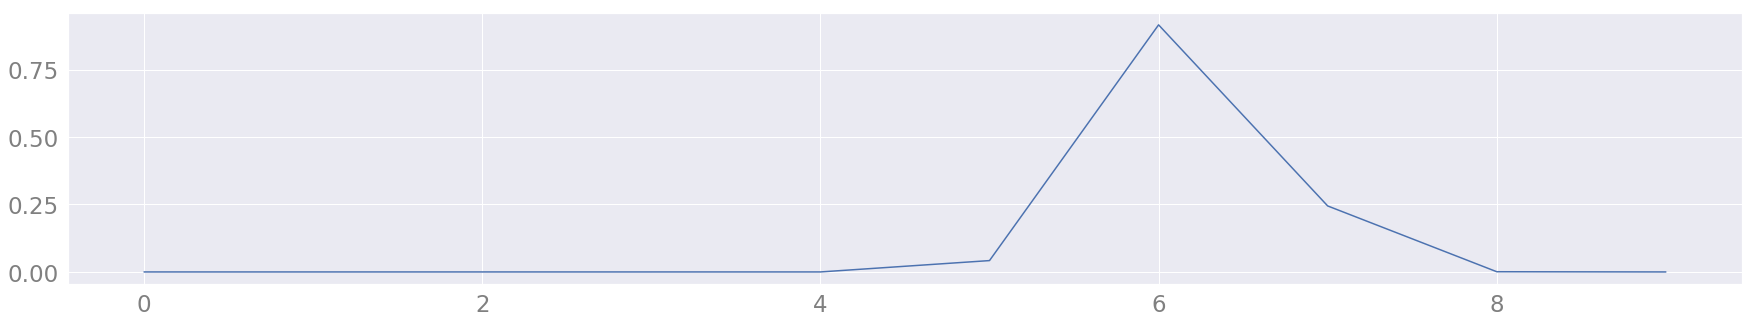

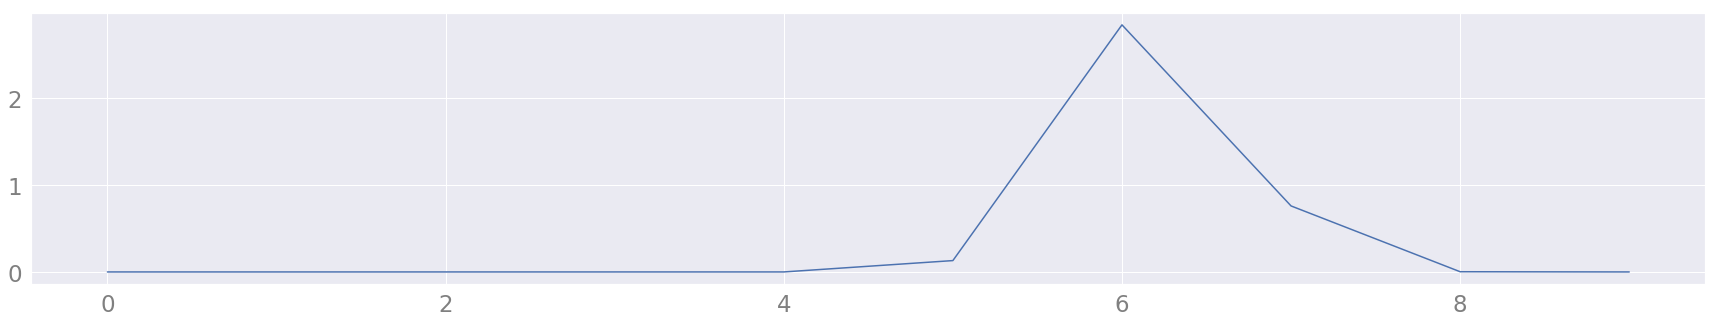

In [59]:
k_ = torch.FloatTensor([6.2])
alpha_ = torch.FloatTensor([3.1])
beta_ = torch.FloatTensor([2.2])
U = 10
u = torch.Tensor(range(U))
kappa_t_ = torch.FloatTensor([k_])
phi_1 = kappa_t_.unsqueeze(1).repeat(1, 1, U) - u
phi_2 = (kappa_t_.unsqueeze(1).repeat(1, 1, U) - u)**2
phi_3 = -beta_*(kappa_t_.unsqueeze(1).repeat(1, 1, U) - u)**2
phi_4 = (-beta_*(kappa_t_.unsqueeze(1).repeat(1, 1, U) - u)**2).exp()
phi_5 = alpha_ * ((-beta_*(kappa_t_.unsqueeze(1).repeat(1, 1, U) - u)**2).exp())
plot(phi_1.squeeze().detach().numpy())
plot(phi_2.squeeze().detach().numpy())
plot(phi_3.squeeze().detach().numpy())
plot(phi_4.squeeze().detach().numpy())
plot(phi_5.squeeze().detach().numpy())

In [60]:
# wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t
# The size of the soft window vectors is the same as the size of the character vectors
# cu (assuming a one-hot encoding, this will be the number of characters in the alphabet).
c, c.shape, phi_t, phi_t.shape

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0]]),
 torch.Size([39, 43]),
 tensor([[7.6739e+00, 2.0579e+01, 8.0059e+00, 5.0109e-01, 6.5565e-03, 2.3256e-05,
          2.3309e-08, 5.9594e-12, 3.5824e-16, 4.8769e-21, 1.4819e-26, 9.9923e-33,
          1.4904e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00]], grad_fn=<SumBackward2>),
 torch.Size([1, 39]))

In [61]:
(phi_t.unsqueeze(2) * c.float())

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)

In [62]:
# wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t
# The size of the soft window vectors is the same as the size of the character vectors
# cu (assuming a one-hot encoding, this will be the number of characters in the alphabet).
wt = (c.float() * phi_t.unsqueeze(2))
#wt = phi_t.transpose(0, 1)*x.float()
wt, wt.shape

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>),
 torch.Size([1, 39, 43]))

Text(0.5, 0.98, 'window weight (t=0)')

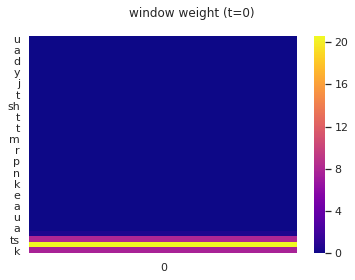

In [63]:
# window weights φ(t, u) during a time step sequence

# the window weight φ(t, u) can be loosely interpreted as
# the network’s belief that it is writing character cu at time t
#frame = pd.DataFrame(w.squeeze(0).detach().numpy(), index=phoneme_names).iloc[::-1]  # reverse by row
frame = pd.DataFrame(phi_t.squeeze(0).detach().numpy(), index=phoneme_names).iloc[::-1]  # reverse by row
sns.heatmap(frame, cmap="plasma")
plt.suptitle('window weight (t=0)')

In [64]:
# φ(t, u) as phi_t, cu as x
phi_t, phi_t.shape, c, c.shape

(tensor([[7.6739e+00, 2.0579e+01, 8.0059e+00, 5.0109e-01, 6.5565e-03, 2.3256e-05,
          2.3309e-08, 5.9594e-12, 3.5824e-16, 4.8769e-21, 1.4819e-26, 9.9923e-33,
          1.4904e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00]], grad_fn=<SumBackward2>),
 torch.Size([1, 39]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0]]),
 torch.Size([39, 43]))

In [92]:
# wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t
# The size of the soft window vectors is the same as the size of the character vectors cu
# (assuming a one-hot encoding, this will be the number of characters in the alphabet).
wt = (phi_t.unsqueeze(-1)*c.float())#.sum(dim=1)
#wt = torch.unique((phi_t.unsqueeze(-1)*c.float()),dim=1)#.sum(dim=1)
#wt = torch.unique((phi_t.unsqueeze(-1)*c.float()),dim=1).sum(dim=1)
wt = (phi_t.unsqueeze(-1)*c.float()).sum(dim=1)
#wt = phi_t  # same?
wt, wt.shape


(tensor([[6.5565e-03, 0.0000e+00, 5.0109e-01, 2.0579e+01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9923e-33, 5.9594e-12,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 7.6739e+00, 8.0060e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]], grad_fn=<SumBackward2>), torch.Size([1, 43]))

In [ ]:
# hnt = H(Wihn xt + Whn-1hn hnt-1 + Whnhn hnt-1 + Wwhn wt + bnh)
xt_1_wt_1_h1t_1 = torch.cat([xt_1, wt_1, ht_1], dim=1)
h2t_1 = H2(xt_1_wt_1_h1t_1, ht_1)
h2t_1.shape

In [66]:
dataset = NeuraVoiceDataset()
loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=dataset.char_to_mel, drop_last=False, num_workers=1)

In [67]:
model = CharToMel(encode_type='onehot', K=20, hidden_size=256, out_size=278)

model version 1
Trainable Parameters: 3.038 million


In [ ]:
train(model, loader)